<a id='0'></a>
# Car Detection Using Tensorflow Object Detection API

In this notebook, I will build a *car detection model* to detect cars in images/videos. I will use the *Tensorflow Object Detection API* to accomplish so. Let's dive in.

---
**Notes:**<br>
- We will use [this dataset](https://www.kaggle.com/datasets/hikmatullahmohammadi/car-detection-tfod) to accomplish so.
- This notebook is built on Google Colab.

# Easy navigation
- [1- Set up the environment](#1)
    - [1.1- Set up the directory structure](#1-1)
    - [1.2- Set up required dependencies](#1-2)
- [2- Data Preprocessing](#2)
- [3- Train and evaluate the model](#3)
    - [3.1- Train the model](#3-1)
    - [3.2- Evaluate the model](#3-2)
- [4- Export the model](#4)
- [5- Run inference with new model](#5)
    - [5.1- Run inference using checkpoints](#5-1)
    - [5.2- Run inference using SaveModel (exported model)](#5-2)

<a id='1'></a>
# 1- Set up environment

<a id='1-1'></a>
## 1.1- Set up the directory structure

In the root folder, create a new folder called *workspace*. It is within the *workspace* that we will store all our training set-ups. Now let’s go under *workspace* and create another folder named *training_demo*.

In [1]:
# create workspace & training_demo folders
%%bash
mkdir workspace
cd workspace
mkdir training_demo

The *training_demo* folder shall be our training folder, which will contain all files related to our model training. It is advisable to create a separate training folder each time we wish to train on a different dataset. The typical structure for training folders is shown below.
```
training_demo/
├─ annotations/
├─ exported-models/
├─ images/
│  ├─ test/
│  └─ train/
├─ models/ssd_modnet_model
├─ pre-trained-models/
```

Let's create the above directory structure

In [2]:
%%bash
cd workspace/training_demo
mkdir annotations
mkdir exported-models
mkdir images
mkdir models
mkdir models/ssd_mobnet_model
mkdir pre-trained-models

In [3]:
# create 'scripts' folder in the root dir to store some useful scripts
%%bash
mkdir scripts

<a id='1-2'></a>
## 1.2- Set up required dependencies

In [4]:
# install Tensorflow version 2.11.0 (latest)
!pip install --upgrade -q pip
!pip install --upgrade -q tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:0000:01




In [5]:
# Clone the tensorflow models repository if it doesn't already exist
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...

remote: Enumerating objects: 3691, done.

remote: Counting objects: 100% (3691/3691), done.

remote: Compressing objects: 100% (3078/3078), done.

remote: Total 3691 (delta 989), reused 1519 (delta 562), pack-reused 0

Receiving objects: 100% (3691/3691), 48.75 MiB | 14.97 MiB/s, done.

Resolving deltas: 100% (989/989), done.


In [6]:
# install COCO for evaluating the model after training it
!pip install -q cython
!pip install -q pycocotools

In [7]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 34.1 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 34.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.1 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 37.6 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.1 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 kB 47.8 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 25.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━

In this particular project, we will use a pretrained model , *ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8*, which you can find on [tf2 detection zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). This model accepts a 640x640 image, and outputs bounding boxes of the detected objects.

In [8]:
# Download the checkpoint (pretrained model) and put it into /content/workspace/training_demo/pre-trained-models
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

# create ssd_modnet_model folder
!mkdir /content/workspace/training_demo/pre-trained-models/ssd_modnet_model
# move the files from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8 to  /content/workspace/training_demo/pre-trained-models/ssd_modnet_model
!mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/* /content/workspace/training_demo/pre-trained-models/ssd_modnet_model/
# remove efficientdet_d1_coco17_tpu-32 folder since it's empty
!rmdir ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8

--2023-03-06 10:58:15--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.10.128, 2404:6800:4003:c06::80

Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.10.128|:80... connected.

HTTP request sent, awaiting response... 200 OK

Length: 20518283 (20M) [application/x-tar]

Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’



ssd_mobilenet_v2_fp 100%[===================>]  19.57M  19.7MB/s    in 1.0s    



2023-03-06 10:58:17 (19.7 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]




In [9]:
# import required libraries/dependencies
import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

<a id='2'></a>
# 2- Data Preprocessing

In [10]:
!pip install -q kaggle # to downlaod the dataset

In [11]:
# we will upload the kaggle.json file which can be obtained from your Kaggle account
from google.colab import files
files.upload()
print('Uploaded kaggle.json')

Saving kaggle.json to kaggle.json

Uploaded kaggle.json


In [12]:
# move the kaggle.json file to ~/.kaggle/ folder and change the access mode
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
# change permission mode:
# 600 permissions means that only the owner of the file has full read and write access to it
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
# download the dataset from Kaggle and unzip the contents, and move it to /content/workspace/training_demo/images folder
%%bash
cd /content/workspace/training_demo/images
kaggle datasets download -d hikmatullahmohammadi/car-detection-tfod -p .  --unzip

# move the dataset from data folder to images folder
mv car-detection-dataset/* . 
# delete data folder
rmdir car-detection-dataset

100%|██████████| 2.92M/2.92M [00:01<00:00, 2.59MB/s]


In [14]:
# move test-annot-xml and train-annot-xml directories to /content/workspace/training_demo/annotations
!mv /content/workspace/training_demo/images/train-annot-xml /content/workspace/training_demo/annotations/train-annot-xml
!mv /content/workspace/training_demo/images/test-annot-xml /content/workspace/training_demo/annotations/test-annot-xml

In [15]:
# create labelmap
labels = [{'name':'car', 'id':1}]
labelmap_path = '/content/workspace/training_demo/annotations/label_map.pbtxt'
with open(labelmap_path, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

**Modify the config file**<br>
We will modify the configuration (config) file of the pretrained model in order to fit into our purpose. For instance, our pretrained model is trained on 1000 classes, but we will change the number of classes to 1 since we are trying to detect only cars.

In [16]:
# copy the pretrained model's config file to /content/workspace/training_demo/models/ssd_modnet_model
config_path = '/content/workspace/training_demo/pre-trained-models/ssd_modnet_model/pipeline.config'
!cp {config_path} /content/workspace/training_demo/models/ssd_mobnet_model/

# re-assign config_path
config_path = '/content/workspace/training_demo/models/ssd_mobnet_model/pipeline.config'

In [17]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)  

In [18]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = '/content/workspace/training_demo/pre-trained-models/ssd_modnet_model/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= labelmap_path
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ['/content/workspace/training_demo/annotations/train.record']
pipeline_config.eval_input_reader[0].label_map_path = labelmap_path
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/content/workspace/training_demo/annotations/test.record']
# add coco for evaluating the model 
pipeline_config.eval_config.metrics_set[0] = "coco_detection_metrics"
pipeline_config.eval_config.use_moving_averages = False

In [19]:
# write the modified config file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(config_path, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

**Generate TFrecord files**<br>
Download *generate_tfrecord.py* file from [this link](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py), and upload it bellow. **Please name it *generate_tfrecord.py* if it is already not so.**

In [20]:
# place generate_tfrecord.py file in scripts folder
from google.colab import files
files.upload() 
!mv generate_tfrecord.py scripts/

Saving generate_tfrecord.py to generate_tfrecord.py


In [23]:
# create tfrecords for training and test sets
%%bash
cd workspace/training_demo/annotations
# train.record
python /content/scripts/generate_tfrecord.py -x train-annot-xml/ -i /content/workspace/training_demo/images/training -l label_map.pbtxt -o train.record
# test.record
python /content/scripts/generate_tfrecord.py -x test-annot-xml/ -i /content/workspace/training_demo/images/test -l label_map.pbtxt -o test.record

Successfully created the TFRecord file: train.record

Successfully created the TFRecord file: test.record


<a id='3'></a>
# 3- Train & evaluate the model

<a id='3-1'></a>
## 3.1- Train the model

In [24]:
# train the model
steps = 2000
!python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/workspace/training_demo/models/ssd_mobnet_model --pipeline_config_path={config_path} --num_train_steps={steps}

2023-03-06 11:06:04.387833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:06:04.387931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:06:04.387949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

2023-03-06 11:06:08.480566: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH enviro

<a id='3-2'></a>
## 3.2- Evaluate the model

In [25]:
# evaluate the model
!python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/workspace/training_demo/models/ssd_mobnet_model --pipeline_config_path={config_path} --checkpoint_dir=/content/workspace/training_demo/models/ssd_mobnet_model

2023-03-06 11:14:00.880873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:14:00.881001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:14:00.881033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


W0306 11:14:04.184357 140553149761344 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.

INFO:tensorflow:Maybe overwriting sample_1_o

---


<p style='padding:10px;font-weight:bold;color:red'>
<b>Tensorboard NOT working</b><br>
I get an error when trying to use tensorboard through running the code bellow, and I could not resolve it. Any help will be highly appreciated.</p>

In [26]:
!tensorboard --logdir=/content/workspace/training_demo/models/my_model

2023-03-06 11:19:26.523301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:19:26.523413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:19:26.523435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.



NOTE: Using experimental fast data loading logic. To disable, pass

    "--load_fast=false" and report issues on GitHub. More details:

    https://github.com/ten

---

<a id='4'></a>
# 4- Export the model

Once your training job is complete, you need to extract the newly trained inference graph, which will later be used to perform the object detection

In [27]:
exporter_main_v2_path = '/content/models/research/object_detection/exporter_main_v2.py'

In [32]:
!python {exporter_main_v2_path} --input_type image_tensor --pipeline_config_path {config_path} --trained_checkpoint_dir /content/workspace/training_demo/models/ssd_mobnet_model --output_directory /content/workspace/training_demo/exported-models

2023-03-06 11:21:05.525849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:21:05.525958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia

2023-03-06 11:21:05.525977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

2023-03-06 11:21:10.486297: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH enviro

In [33]:
# copy the lablemap to the exported model's assets folder
!cp {labelmap_path} /content/workspace/training_demo/exported-models/saved_model/assets

**Zip the exported model**

In [35]:
# zip the exported model to be able to transform it easily
!zip -r /content/workspace/training_demo/exported-models/car-detection-model-ssd.zip /content/workspace/training_demo/exported-models


  adding: content/workspace/training_demo/exported-models/ (stored 0%)

  adding: content/workspace/training_demo/exported-models/checkpoint/ (stored 0%)

  adding: content/workspace/training_demo/exported-models/checkpoint/checkpoint (deflated 42%)

  adding: content/workspace/training_demo/exported-models/checkpoint/ckpt-0.index (deflated 80%)

  adding: content/workspace/training_demo/exported-models/checkpoint/ckpt-0.data-00000-of-00001 (deflated 8%)

  adding: content/workspace/training_demo/exported-models/.ipynb_checkpoints/ (stored 0%)

  adding: content/workspace/training_demo/exported-models/pipeline.config (deflated 69%)

  adding: content/workspace/training_demo/exported-models/saved_model/ (stored 0%)

  adding: content/workspace/training_demo/exported-models/saved_model/saved_model.pb (deflated 92%)

  adding: content/workspace/training_demo/exported-models/saved_model/variables/ (stored 0%)

  adding: content/workspace/training_demo/exported-models/saved_model/variables/

---

<a id='5'></a>
# 5- Run inferences with new model

<a id='5-1'></a>
## 5.1- Run inference using checkpoints

In [36]:
# utills
def load_image_into_numpy_array(path):
    """
    Load an image from file into a numpy array.
    """
    img = tf.keras.preprocessing.image.load_img(path)
    return tf.keras.preprocessing.image.img_to_array(img)

In [37]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(config_path)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/content/workspace/training_demo/models/ssd_mobnet_model/ckpt-3').expect_partial()

# you can also use the following checkpoint which is the exported model's
# instead of the above checkpoint, but they are the same
# '/content/workspace/training_demo/exported-models/checkpoint/ckpt-0'

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


Instructions for updating:

Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


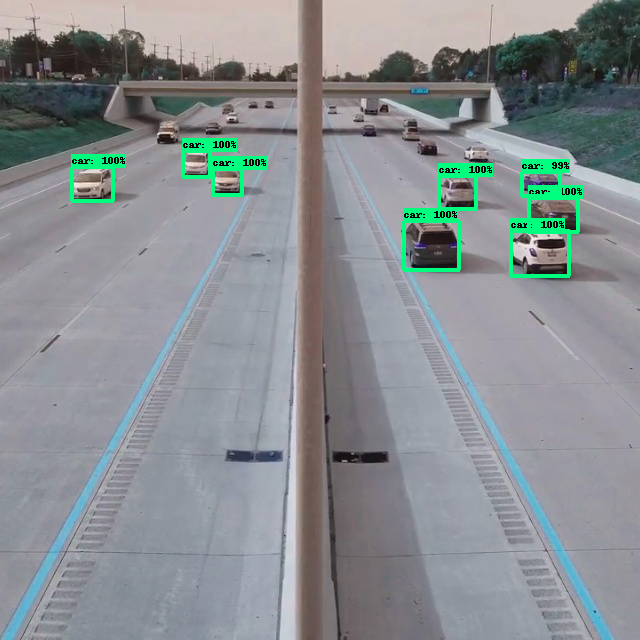

In [38]:
test_image_path = '/content/workspace/training_demo/images/test/test-0.jpg'

# create category index from labelmap: used in visualizing the detections
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path)

image_np = load_image_into_numpy_array(test_image_path)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

dt_boxes = detections['detection_boxes']
dt_classes = detections['detection_classes']+1
dt_scores = detections['detection_scores']

# visualize the detections
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    dt_boxes,
    dt_classes,
    dt_scores,
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.8
)

# show the image
from google.colab.patches import cv2_imshow
cv2_imshow(image_np_with_detections)

---

<a id='5-2'></a>
## 5.2- Run inference using SavedModel format

In [39]:
# load saved model
from object_detection.utils import label_map_util

# Load saved model and build the detection function
detect_fn_saved_model = tf.saved_model.load('/content/workspace/training_demo/exported-models/saved_model')

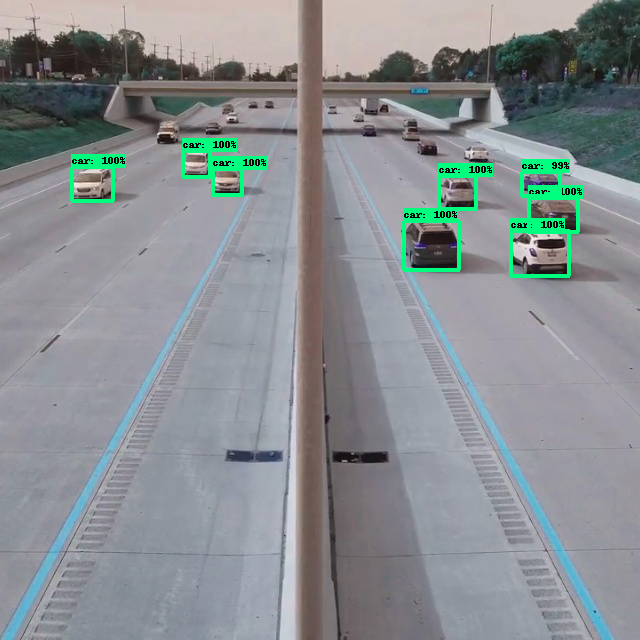

In [40]:
test_image_path = '/content/workspace/training_demo/images/test/test-0.jpg'

# create category index from labelmap: used in visualizing the detections
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path)

image_np = load_image_into_numpy_array(test_image_path)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)

# create category index from labelmap: used in visualizing the detections
category_index = label_map_util.create_category_index_from_labelmap('/content/workspace/training_demo/exported-models/saved_model/assets/label_map.pbtxt')

# detect objects
detections = detect_fn_saved_model(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

dt_boxes = detections['detection_boxes']
dt_classes = detections['detection_classes']
dt_scores = detections['detection_scores']

# visualize the detections
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    dt_boxes,
    dt_classes,
    dt_scores,
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.8
)

# show the image
from google.colab.patches import cv2_imshow
cv2_imshow(image_np_with_detections)

----

**NOTE:**<br>
We built trained a Car Detection model using *Tensorflow Object Detection API (TFOD)*. We will use this model to create a real time Car Counter project. Please visit [this Github repo](https://github.com/hikmatullah-mohammadi/car-detection-and-counting-tfod) to see Car Counter project developed using this model and Open-cv.

# Thank you:)
**By [Hikmatullah Mohammadi](https://www.kaggle.com/hikmatullahmohammadi)<br>**
[Go to top](#0)